In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import seaborn as sns
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
data = pd.read_csv("dataset.csv", encoding='latin1')
data = data[['sentiment', 'text']]
data.isnull().sum()

sentiment    0
text         0
dtype: int64

In [9]:
data.head()

,sentiment,text
0,1,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
1,1,@apple Contact sync between Yosemite and iOS8 ...
2,1,WARNING IF YOU BUY AN IPHONE 5S UNLOCKED FROM ...
3,1,"@Apple, For the love of GAWD, CENTER the '1'on..."
4,1,i get the storage almost full notification lit...


In [27]:
data['sentiment'].replace('not_relevant',4,inplace=True)
data["sentiment"].value_counts()

sentiment
3    2162
1    1219
5     423
4      82
Name: count, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

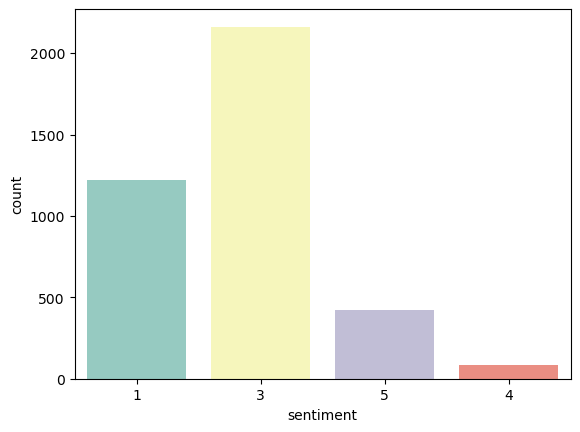

In [26]:
sns.countplot(x="sentiment",data=data, palette="Set3")

In [21]:
def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)
    tweet = re.sub(r'@[A-Za-z0-9_]+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'\S+@\S+', '', tweet)
    tokens = word_tokenize(tweet)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    preprocessed_tweet = ' '.join(tokens)
    return preprocessed_tweet

preprocessed_tweets = [preprocess_tweet(tweet) for tweet in data['text']]
data['text'] = preprocessed_tweets
data['text'].head()


0                       wtf battery one second ago wtf
1    contact sync yosemite io seriously screwed use...
2    warning buy iphone unlocked iphone use verizon...
3    love gawd center damn calendar app fixed back ...
4    get storage almost full notification literally...
Name: text, dtype: object

In [28]:
data["sentiment"]=data["sentiment"].astype(int)

In [31]:
X = data['text']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
X_train_ngrams = ngram_vectorizer.fit_transform(X_train)
X_test_ngrams = ngram_vectorizer.transform(X_test)


In [53]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron

classifiers = {
    'Naïve Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Perceptron': Perceptron()
}
log_reg = LogisticRegression(max_iter=1000)
classifiers['Logistic Regression'] = log_reg

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = {}
averages=['macro','micro']
for avg in averages:
    for clf_name, clf in classifiers.items():
        clf.fit(X_train_counts, y_train)
        y_pred = clf.predict(X_test_counts)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=avg,zero_division=1)
        recall = recall_score(y_test, y_pred, average=avg)
        f1 = f1_score(y_test, y_pred, average=avg)
        results[(clf_name,avg)]= {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}


In [73]:
results_df = pd.DataFrame(results)
# I am Transposing the DataFrame to have classifiers as rows and metrics as columns
results_df = results_df.T
results_df['Feature Extraction Technique']='Bag of words based on raw counts'
results_df

,,Accuracy,Precision,Recall,F1,Feature Extraction Technique
Naïve Bayes,macro,0.717224,0.477087,0.441477,0.445683,Bag of words based on raw counts
Logistic Regression,macro,0.749357,0.531413,0.453415,0.469815,Bag of words based on raw counts
Random Forest,macro,0.727506,0.519248,0.431936,0.449526,Bag of words based on raw counts
SVM,macro,0.735219,0.814025,0.419849,0.433445,Bag of words based on raw counts
Perceptron,macro,0.728792,0.521163,0.453980,0.472327,Bag of words based on raw counts
Naïve Bayes,micro,0.717224,0.717224,0.717224,0.717224,Bag of words based on raw counts
Logistic Regression,micro,0.749357,0.749357,0.749357,0.749357,Bag of words based on raw counts
Random Forest,micro,0.737789,0.737789,0.737789,0.737789,Bag of words based on raw counts
SVM,micro,0.735219,0.735219,0.735219,0.735219,Bag of words based on raw counts
Perceptron,micro,0.728792,0.728792,0.728792,0.728792,Bag of words based on raw counts


In [70]:
results_tfidf = {}
averages=['macro','micro']
for avg in averages:
    for clf_name, clf in classifiers.items():
        clf.fit(X_train_tfidf, y_train)
        y_pred = clf.predict(X_test_tfidf)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=avg,zero_division=1)
        recall = recall_score(y_test, y_pred, average=avg)
        f1 = f1_score(y_test, y_pred, average=avg)
        results_tfidf[(clf_name,avg)] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}

In [71]:
results_df2 = pd.DataFrame(results_tfidf)
results_df2 = results_df2.T
results_df2['Feature Extraction Technique']='Bag of words based on TfIDF'
results_df2

,,Accuracy,Precision,Recall,F1,Feature Extraction Technique
Naïve Bayes,macro,0.736504,0.838757,0.415240,0.417829,Bag of words based on TfIDF
Logistic Regression,macro,0.754499,0.816921,0.445115,0.460718,Bag of words based on TfIDF
Random Forest,macro,0.721080,0.511903,0.416928,0.431221,Bag of words based on TfIDF
SVM,macro,0.749357,0.837212,0.437398,0.453886,Bag of words based on TfIDF
Perceptron,macro,0.688946,0.483669,0.460989,0.467899,Bag of words based on TfIDF
Naïve Bayes,micro,0.736504,0.736504,0.736504,0.736504,Bag of words based on TfIDF
Logistic Regression,micro,0.754499,0.754499,0.754499,0.754499,Bag of words based on TfIDF
Random Forest,micro,0.719794,0.719794,0.719794,0.719794,Bag of words based on TfIDF
SVM,micro,0.749357,0.749357,0.749357,0.749357,Bag of words based on TfIDF
Perceptron,micro,0.688946,0.688946,0.688946,0.688946,Bag of words based on TfIDF


In [74]:
results_ngrams = {}
averages=['macro','micro']
for avg in averages:
    for clf_name, clf in classifiers.items():
        clf.fit(X_train_ngrams, y_train)
        y_pred = clf.predict(X_test_ngrams)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=avg,zero_division=1)
        recall = recall_score(y_test, y_pred, average=avg)
        f1 = f1_score(y_test, y_pred, average=avg)
        results_ngrams[(clf_name,avg)] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}

In [75]:
results_df3 = pd.DataFrame(results_ngrams)
results_df3 = results_df3.T
results_df3['Feature Extraction Technique']='ngrams (unigrams, bigrams, trigrams)'
results_df3

,,Accuracy,Precision,Recall,F1,Feature Extraction Technique
Naïve Bayes,macro,0.739075,0.759537,0.433275,0.435328,"ngrams (unigrams, bigrams, trigrams)"
Logistic Regression,macro,0.742931,0.531160,0.440159,0.455817,"ngrams (unigrams, bigrams, trigrams)"
Random Forest,macro,0.712082,0.771039,0.416281,0.433935,"ngrams (unigrams, bigrams, trigrams)"
SVM,macro,0.691517,0.847945,0.379794,0.389889,"ngrams (unigrams, bigrams, trigrams)"
Perceptron,macro,0.728792,0.510926,0.465705,0.482563,"ngrams (unigrams, bigrams, trigrams)"
Naïve Bayes,micro,0.739075,0.739075,0.739075,0.739075,"ngrams (unigrams, bigrams, trigrams)"
Logistic Regression,micro,0.742931,0.742931,0.742931,0.742931,"ngrams (unigrams, bigrams, trigrams)"
Random Forest,micro,0.713368,0.713368,0.713368,0.713368,"ngrams (unigrams, bigrams, trigrams)"
SVM,micro,0.691517,0.691517,0.691517,0.691517,"ngrams (unigrams, bigrams, trigrams)"
Perceptron,micro,0.728792,0.728792,0.728792,0.728792,"ngrams (unigrams, bigrams, trigrams)"


In [76]:
df = pd.concat([results_df,results_df2,results_df3], axis=0)
df.to_csv('Report.csv', index=True)
df

,,Accuracy,Precision,Recall,F1,Feature Extraction Technique
Naïve Bayes,macro,0.717224,0.477087,0.441477,0.445683,Bag of words based on raw counts
Logistic Regression,macro,0.749357,0.531413,0.453415,0.469815,Bag of words based on raw counts
Random Forest,macro,0.727506,0.519248,0.431936,0.449526,Bag of words based on raw counts
SVM,macro,0.735219,0.814025,0.419849,0.433445,Bag of words based on raw counts
Perceptron,macro,0.728792,0.521163,0.453980,0.472327,Bag of words based on raw counts
Naïve Bayes,micro,0.717224,0.717224,0.717224,0.717224,Bag of words based on raw counts
Logistic Regression,micro,0.749357,0.749357,0.749357,0.749357,Bag of words based on raw counts
Random Forest,micro,0.737789,0.737789,0.737789,0.737789,Bag of words based on raw counts
SVM,micro,0.735219,0.735219,0.735219,0.735219,Bag of words based on raw counts
Perceptron,micro,0.728792,0.728792,0.728792,0.728792,Bag of words based on raw counts
